Source: https://github.com/randerson112358/Python/blob/master/LSTM_Stock/LSTM2.ipynb

In [1]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as web

/usr/local/miniconda3/envs/mimic3/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from train_utils import train_model

In [5]:
np.random.seed(4321)
torch.manual_seed(4321)

In [6]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.857235
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.130558
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.698215
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.238651
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.155792
...,...,...,...,...,...,...
2019-12-11,271.100006,268.500000,268.809998,270.769989,19689200.0,269.399658
2019-12-12,272.559998,267.320007,267.779999,271.459991,34327600.0,270.086151
2019-12-13,275.299988,270.929993,271.459991,275.149994,33396900.0,273.757477


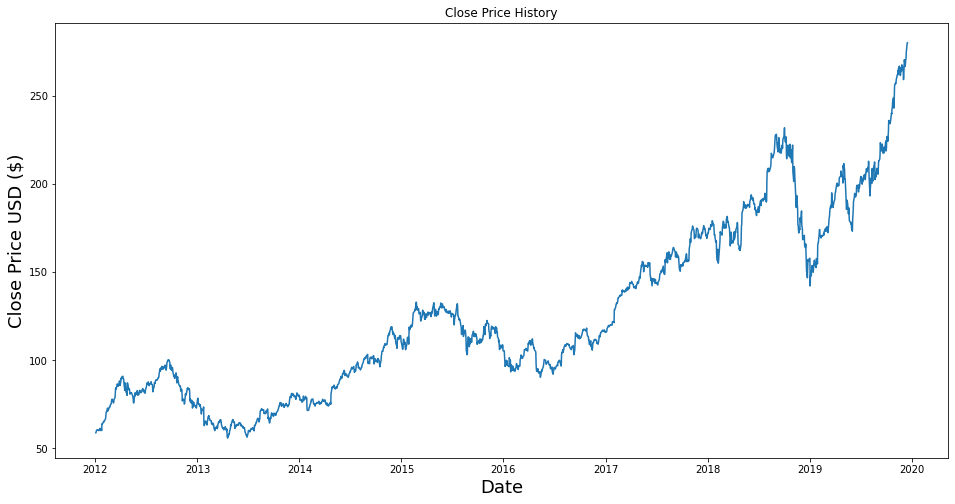

In [7]:
plt.figure(figsize=(16, 8))
plt.title("Close Price History")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.show()

In [8]:
data = df.filter(["Close"]).astype(np.float32)
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1603

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01316509],
       [0.01457062],
       [0.01748985],
       ...,
       [0.97658265],
       [0.99755144],
       [1.0000001 ]], dtype=float32)

In [10]:
STEP = 60

In [11]:
train_data = scaled_data[0:training_data_len, :]

x_train = np.array([train_data[i-STEP:i, 0] for i in range(STEP, training_data_len)])
y_train = np.array([train_data[i, 0] for i in range(STEP, training_data_len)])

In [12]:
ENTRY_COUNT = len(y_train)

In [13]:
x_train = x_train.reshape(ENTRY_COUNT, STEP, 1)
x_train.shape

(1543, 60, 1)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
train_dl = torch.utils.data.DataLoader([(x_train[i], y_train[i]) for i in range(len(y_train))], shuffle=True, batch_size=50)
val_dl = torch.utils.data.DataLoader([(x_val[i], y_val[i]) for i in range(len(y_val))], shuffle=True, batch_size=50)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(1, 50, num_layers=1)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
    
    def regularizer(self):
        return torch.tensor(0.0)
    
    def forward(self, x):
        result, _ = self.rnn(x)
        result = result[-1]
        result = torch.relu(self.fc1(result))
        result = self.fc2(result)
        return result, None

In [16]:
net = Net()
def criterion(output, y):
    y_pred, _ = output
    return torch.mean((y_pred-y.view(-1,1))**2)

optimizer = optim.Adam(net.parameters(), lr=0.001)

In [17]:
%%time
net = train_model(net, train_dl, val_dl, criterion, optimizer, "stock.pt", 100, metrics=[], patience=6)

[1, 100.00%] train loss: 0.078803
[1, 100.00%] validate loss: 0.018035
[2, 100.00%] train loss: 0.017868
[2, 100.00%] validate loss: 0.015997
[3, 100.00%] train loss: 0.012506
[3, 100.00%] validate loss: 0.011114
[4, 100.00%] train loss: 0.005847
[4, 100.00%] validate loss: 0.003360
[5, 100.00%] train loss: 0.002662
[5, 100.00%] validate loss: 0.002227
[6, 100.00%] train loss: 0.001276
[6, 100.00%] validate loss: 0.001110
[7, 100.00%] train loss: 0.000784
[7, 100.00%] validate loss: 0.000771
[8, 100.00%] train loss: 0.000561
[8, 100.00%] validate loss: 0.000610
[9, 100.00%] train loss: 0.000464
[9, 100.00%] validate loss: 0.000524
[10, 100.00%] train loss: 0.000428
[10, 100.00%] validate loss: 0.000497
[11, 100.00%] train loss: 0.000399
[11, 100.00%] validate loss: 0.000468
[12, 100.00%] train loss: 0.000384
[12, 100.00%] validate loss: 0.000463
[13, 100.00%] train loss: 0.000361
[13, 100.00%] validate loss: 0.000458
[14, 100.00%] train loss: 0.000374
[14, 100.00%] validate loss: 0.000

In [18]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = torch.tensor([test_data[i-60:i, 0] for i in range(60, len(test_data))])
y_test = dataset[training_data_len:,:]
x_test = x_test.reshape(len(x_test), STEP, 1)

In [19]:
net.eval()
with torch.no_grad():
    predictions, _ = net(x_test.transpose(1, 0))
    predictions = predictions.numpy()
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

In [20]:
rmse = np.sqrt(np.mean((predictions-y_test)**2))
rmse

5.893952

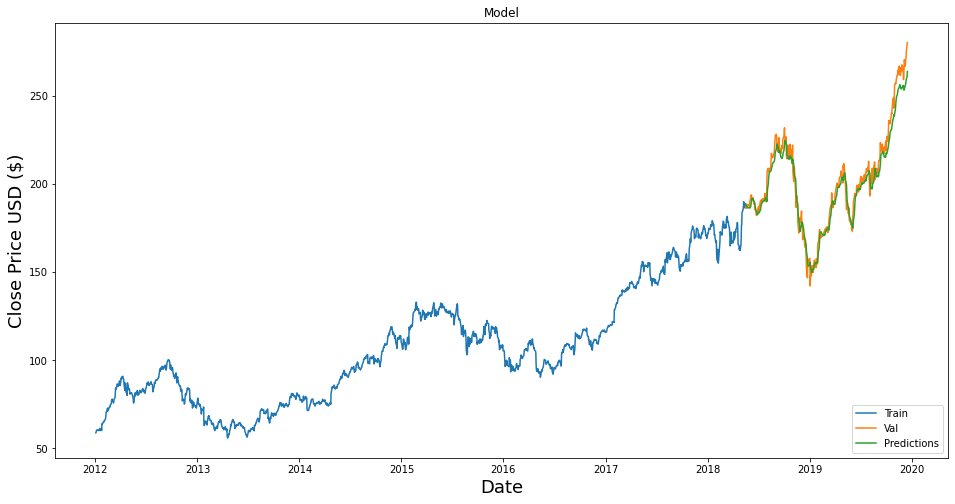

In [21]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid.insert(1,"Predictions",predictions)

plt.figure(figsize=(16, 8))
plt.title("Model")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

In [22]:
valid

,Close,Predictions
Date,,
2018-05-17,186.990005,188.993591
2018-05-18,186.309998,188.313126
2018-05-21,187.630005,187.431564
2018-05-22,187.160004,187.016556
2018-05-23,188.360001,186.548035
...,...,...
2019-12-11,270.769989,257.205139
2019-12-12,271.459991,258.465515
2019-12-13,275.149994,259.593689
